# Exercise 2: Solar Compass from Polarization Images
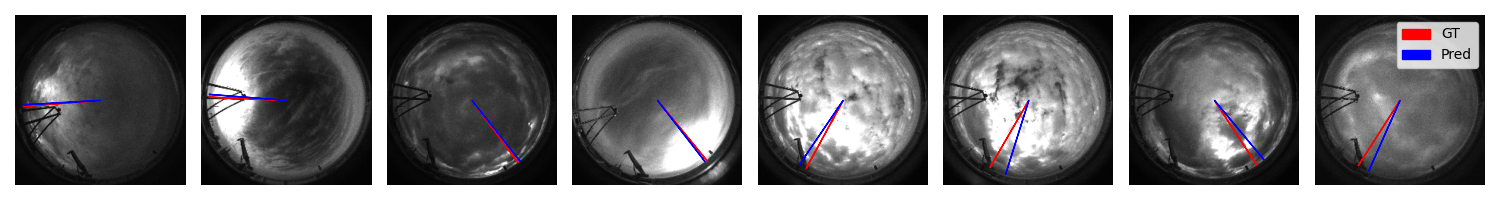
---
## Table of Contents
1. [Introduction](#introduction)
2. [Tool: Hydra](#tool-hydra)
    - [Hiearachical Configs](#hiearachical-configs)
    - [Default Lists](#default-lists)
    - [Variable Interpolation](#variable-interpolation)
    - [Optional Default Lists and `_self_`](#optional-defaults-list-and-_self_)
    - [Instantiate API](#instantiate-api)
3. [Tip: autoreload in Jupyter Notebooks](#tip-autoreload-in-jupyter-notebooks)
4. [Polarized Images](#polarized-images)
5. [Feature Selection](#feature-selection)
6. [Backbone](#backbone)
7. [Data Augmentation](#data-augmentation)
8. [CUDA (GPU Acceleration)](#cuda-gpu-acceleration)
9. [Training Loop](#training-loop)
    - [Tool: Tensorboard](#tool-tensorboard)


## Introduction
In this exercise, you will be tasked with building a neural network solution to estimate sun direction from images captured by a polarized camera. You will apply knowledge about data augmentation, convolutional networks into practice.

The goal is to train a model that predicts the sun’s direction based on polarized images. Accurate heading estimation is crucial for outdoor autonomous navigation, where robots typically rely on magnetometers. However, these sensors are vulnerable to electromagnetic interference. Inspired by insects’ ability to navigate using skylight polarization, this method presents a promising alternative.

To facilitate this, we have collected a dataset of polarized skylight images from the rooftop of our AE building. By using the exact timestamps and GPS coordinates of the images, we have deduced the sun’s direction as ground truth. Your task is to train a neural network using this ground truth data and develop a model robust enough to be deployed in real-world conditions.

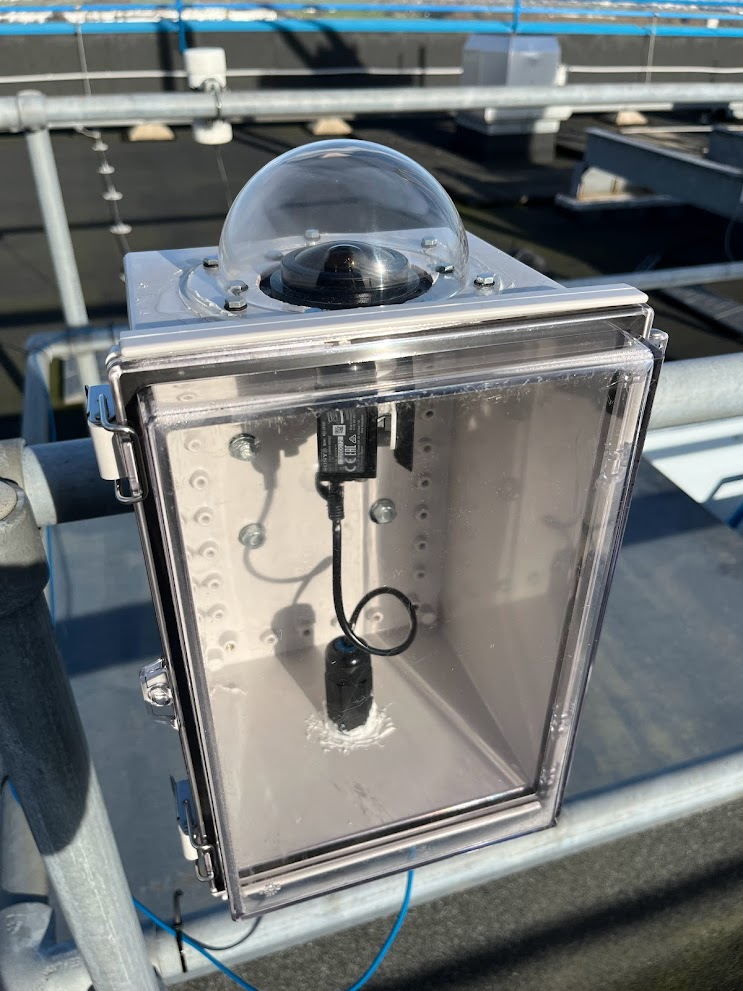

## Tool: Hydra
---
As the complexity of your machine learning program grows, you will find that the number of hyperparameters and configuration options increases significantly. Managing these parameters in a single YAML file can quickly become overwhelming, leading to inflexible setups and hard-to-reproduce experiments. [Hydra](https://hydra.cc/docs/intro/) addresses this challenge by providing a powerful configuration management system that allows you to easily organize, override, and experiment with different settings. It streamlines the process of managing hyperparameters, datasets, models, and other components, making it easier to scale your projects, experiment with various setups, and maintain clear, flexible, and reproducible workflows.

We will illustrate its basic features with `ex_2/config/train.yaml`.

### Hiearachical Configs
In Hydra, configurations can be organized into hierarchical parameter groups. For instance, parameters like `epochs` can be set at the top level. However, certain components, such as the model, optimizer, dataset, and dataloader, often require multiple hyperparameters for a complete definition.

Take the optimizer as an example: it typically needs at least the optimizer type (e.g., Adam) and the learning rate. In such cases, related parameters can be grouped together by nesting them under a line with the format `<group_name>:` (e.g., `optimizer:`), using indentation to indicate their association. After the config is read into Python as `cfg`, you can access this group of parameters by `cfg.<group_name>`.

Note that parameter groups can be nested within other parameter groups. For example, the `demo` parameter group contains two subgroups, `param_group_1` and `param_group_2`. Calling `cfg.demo` would return all parameters within the group, including those from its subgroups.

### Default Lists
In machine learning experiments, ablation studies are often necessary. For instance, one may need to test various model architectures or experiment with different loss functions to select the optimal approach. In such cases, it is highly useful to define parameters for different options in separate YAML files, and later easily switching between these options using Hydra’s default lists mechanism.

In our case, we have defined such modules in `config/model/backbone`, `config/model/representation`, `config/model/readout`. In `train.yaml`, for each default list options, you can specify the filename (without the `.yaml`) in the corresponding folder to select your desired configs for that parameter group.

For example, in our `train.yaml`, if we choose `vanilla` as the setting for `model/backbone`, Hydra will read the parameters in `vanilla.yaml` file under `config/model/backbone` and put it under the parameter group `model.backbone`.

We can also override the destination for parameters in default lists. By default, parameters are placed in a group based on the file’s location. For example, files in `model/backbone` would be placed under the `model.backbone` parameter group. However, by using the `@` symbol, we can override this destination. For instance, we overrode the destination of parameters in the `config/lr` folder to be placed under the `optimizer` parameter group, ensuring the learning rate settings in those files are properly registered as part of the optimizer configuration.

### Variable Interpolation
When selecting configurations for default lists, one often needs to select according to the options set for some other default lists. For example, the learning rate for an experiment depends on the model architecture to be trained, hence we need an optimal learning rate for each of the model architecture. We could use Hydra's variable interpolation scheme. As an example, for the `lr` option, `${model/backbone}_${model/representation}_${model/readout}` is going to be resolved into `vanilla_IQU_angle` or `resnet_raw_vector` depending on the settings.

### Optional Defaults List and `_self_`
By default, Hydra fails with an error if a config specified in the defaults does not exist. The `optional` argument preceding the defaults item (e.g. our `lr` setting) instructs Hydra to ignore it if the specified config cannot be found.

When constructing the configuration, Hydra processes the defaults list from top to bottom. The `_self_` entry represents the parameters defined in the current YAML file, outside the defaults list. By placing `_self_` at the beginning of the defaults list, the parameters in the defaults will override the locally defined ones. Conversely, placing `_self_` at the end (or omitting it, as Hydra automatically appends it at the end) ensures that locally defined parameters take precedence over those in the defaults list.

### Instantiate API
In PyTorch, it’s common to instantiate models, loss functions, optimizers, and other components using a long list of hyperparameters to configure experiments. We could manually retrieve these parameters from Hydra and instantiate objects like this:

```python
from dataset import PolImgDataset

dataset = PolImgDataset(cfg.dataset.dataset_path, cfg.dataset.prefix)
```

However, using Hydra's `instantiate` API, we can achieve the same result in a single line, even without needing the `import` statement:

```python
dataset = instantiate(cfg.dataset)
```

This approach simplifies the code, enhances readability, and minimizes the risk of errors from manually specifying all the arguments.

## Tip: autoreload in Jupyter Notebooks
In a Jupyter notebook, the `%load_ext autoreload` and `%autoreload 2` commands are used to automatically reload any imported Python modules you modify, without needing to restart the kernel or manually re-import the module. You only need to run these commands once at the beginning of your notebook. After doing so, the autoreload extension will remain active, ensuring that any changes you make to your code (e.g. `ex_2/model.py`) are immediately reflected when you re-run cells. This makes it easier and more efficient to iterate on your code as you develop, since you don’t have to worry about re-importing the modules or restarting your kernel to see the updates you made.

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

import hydra
from hydra.utils import instantiate
from omegaconf import OmegaConf


with hydra.initialize(version_base=None, config_path="./config"):
    cfg = hydra.compose(config_name="train")
    print(OmegaConf.to_yaml(cfg))

epochs: 50
demo:
  param_group_1:
    param_1: a
    param_2: 123
  param_group_2:
    param_1: b
    param_2: 456
dataloader:
  _target_: torch.utils.data.DataLoader
  _partial_: true
  batch_size: 32
  shuffle: true
  num_workers: 0
model:
  _target_: ex_2.model.PolarSunNet
  backbone:
    _target_: ex_2.model.VanillaCNN
    _partial_: true
    last_layer_bias: true
  representation:
    _target_: ex_2.model.get_representation_layer
    representation: raw
  readout:
    _target_: ex_2.model.get_readout_layer
    readout: angle
optimizer:
  _target_: torch.optim.Adam
  _partial_: true
  lr: 1.0
dataset:
  _target_: ex_2.dataset.PolImgDataset
  dataset_path: /workspaces/ae4353-public/data/polarization_dataset
  h5: true
  prefix: ''
  augment: true
loss:
  _target_: ex_2.loss.mse
  _partial_: true



We now instantiate all the components needed to train our model. Since the data is captured continuously over time, to prevent any overlap between the training and validation sets, we use the first 85% of the samples for training and the final 15% for validation.

⚠️ We have provided the code for the dataset, dataloader, and loss function to save you time during the exercises. However, if you’re unfamiliar with how to implement these modules, we encourage you to review the code. You will need to implement them on your own for the competition, and they may also be tested in the final exam.

In [2]:
from torch.utils.data import Subset

model = instantiate(cfg.model)
train_dataset = instantiate(cfg.dataset)
split_index = int(0.85 * len(train_dataset))
train_set = Subset(train_dataset, range(0, split_index))
val_dataset = instantiate(cfg.dataset)
val_dataset.augment = False
val_set = Subset(val_dataset, range(split_index, len(val_dataset)))
train_loader = instantiate(cfg.dataloader)(train_set)
val_loader = instantiate(cfg.dataloader)(val_set)
optimizer = instantiate(cfg.optimizer)(model.parameters())
criterion = instantiate(cfg.loss)

## Polarized Images

Polarization cameras, like the Sony XCG-CP510 used in this dataset, capture not just the intensity and color of light but also detailed information about its polarization state. For each pixel in an image, these cameras typically produce a 4-dimensional vector, corresponding to the light intensity through polarizers oriented at four different angles: 0°, 45°, 90°, and 135°. These angles correspond to the following components:

- **0° Polarization ($I_0$)**: Intensity of light polarized horizontally.
- **45° Polarization ($I_{45}$)**: Intensity of light polarized at a 45° angle.
- **90° Polarization ($I_{90}$)**: Intensity of light polarized vertically.
- **135° Polarization ($I_{135}$)**: Intensity of light polarized at 135°.

<center>
<img src="assets/pol_angles.png" alt="image" width="250">
</center>

These four intensities allow for the calculation of the Stokes parameters: I, Q, and U, which describe the polarization state of the light.

- $I=\frac{1}{2} (I_0 + I_{45} + I_{90} + I_{135})$: The total intensity, representing the sum or average of the polarized intensities, providing the overall brightness of the light.
- $Q=I_0-I_{90}$: The difference in intensity between horizontally (0°) and vertically (90°) polarized light, indicating the degree of linear polarization along these axes.
- $U=I_{45}-I_{135}$: The difference in intensity between diagonally polarized light at 45° and 135°, complementing Q by describing linear polarization along diagonal axes.

In addition to IQU, two other important quantites can be derived: the Degree of Polarization (DOP) and the Angle of Polarization (AOP).

- $DOP = \frac{\sqrt{Q^2 + U^2}}{I}$ Degree of Polarization measures the fraction of light that is polarized compared to the total light intensity.

- $AOP = \frac{1}{2} \tan^{-1}\left(\frac{U}{Q}\right)$ Angle of Polarization describes the angle at which the light is polarized.

/workspaces/ae4353-public/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),


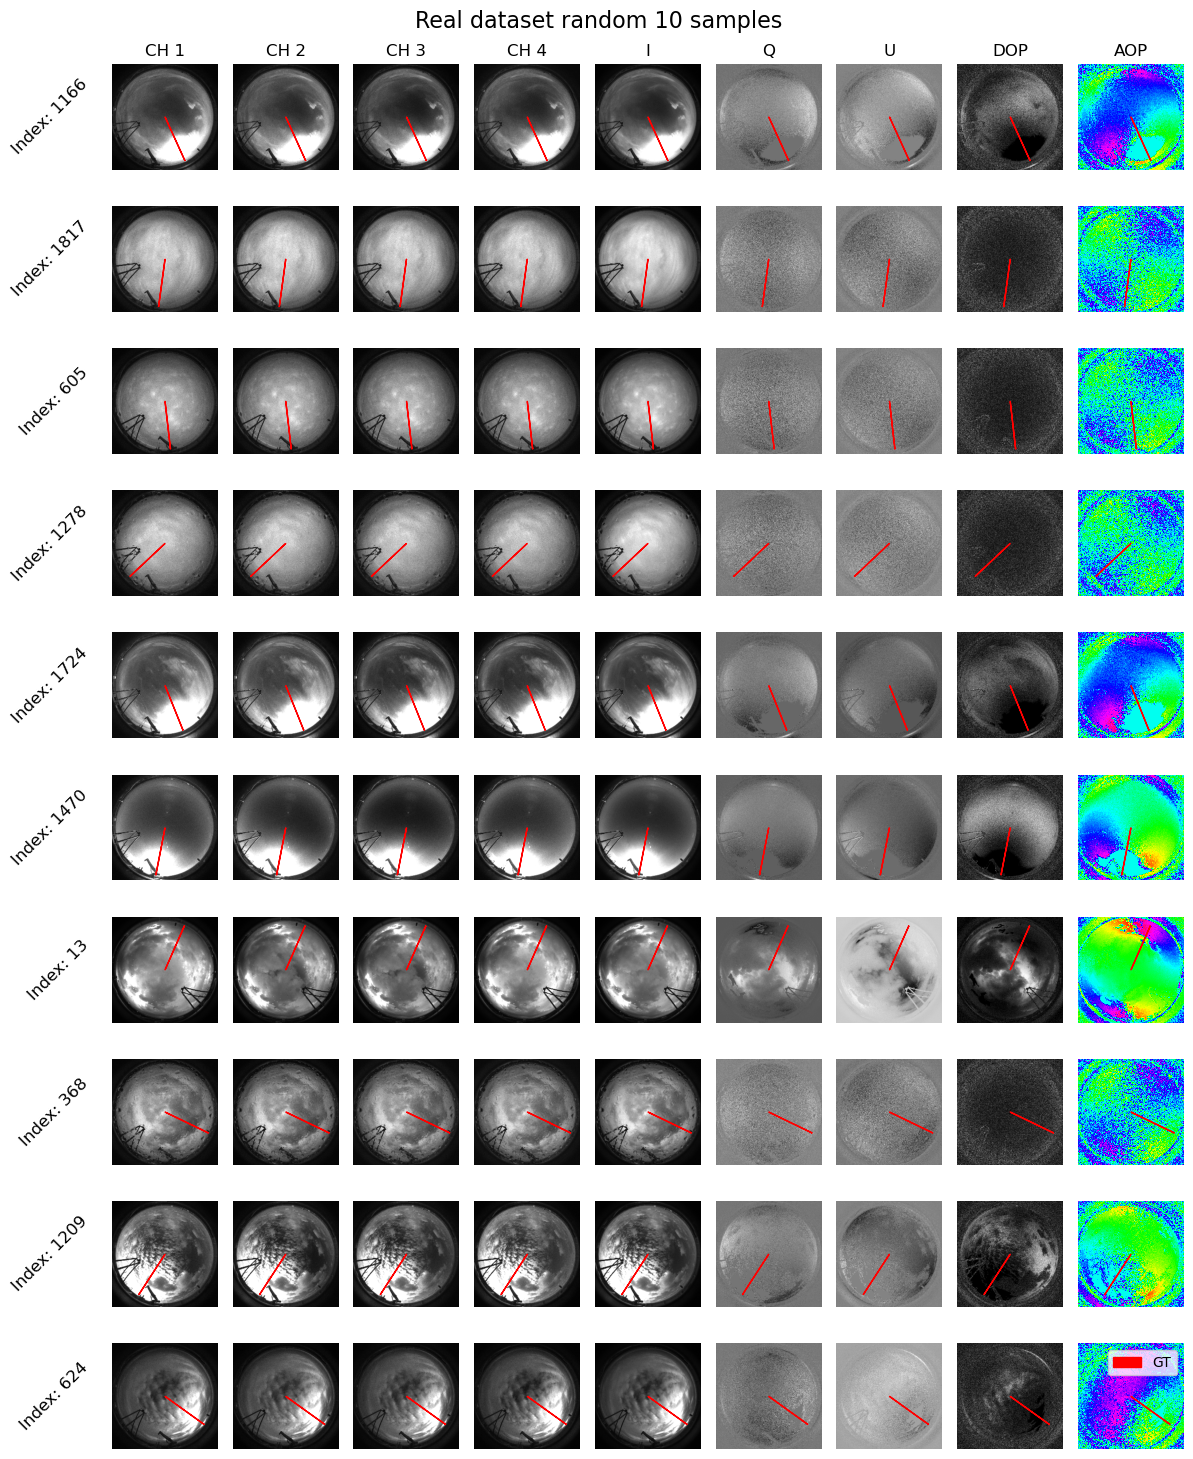

In [3]:
import random
import matplotlib.pyplot as plt
import torch

for dataset, dataset_name in zip([train_dataset], ["Real"]):
    n_samples = 10
    fig, axes = plt.subplots(n_samples, 9, figsize=(12, 15))

    sample_indexes = random.sample(range(len(dataset)), n_samples)
    start_pos = dataset[0][0][0].shape[1] // 2, dataset[0][0][0].shape[0] // 2
    radius = dataset[0][0][0].shape[0] // 2 * 0.9

    for i, idx in enumerate(sample_indexes):
        sample = dataset[idx]
        for j in range(9):
            axes[i, j].axis("off")
            axes[i, j].arrow(
                start_pos[0],
                start_pos[1],
                radius * sample[1][0],
                radius * -sample[1][1],
                color="red",
                head_width=1,
                label="GT",
            )

        axes[i, 0].imshow(sample[0][0], cmap="gray")
        axes[0, 0].set_title("CH 1")

        axes[i, 1].imshow(sample[0][1], cmap="gray")
        axes[0, 1].set_title("CH 2")

        axes[i, 2].imshow(sample[0][2], cmap="gray")
        axes[0, 2].set_title("CH 3")

        axes[i, 3].imshow(sample[0][3], cmap="gray")
        axes[0, 3].set_title("CH 4")

        I = 0.5 * sample[0].sum(axis=0)
        Q = sample[0][0] - sample[0][2]
        U = sample[0][1] - sample[0][3]
        DOP = (Q**2 + U**2) ** 0.5 / I
        AOP = 0.5 * torch.arctan2(U, Q)

        axes[i, 4].imshow(I, cmap="gray")
        axes[0, 4].set_title("I")

        axes[i, 5].imshow(Q, cmap="gray")
        axes[0, 5].set_title("Q")

        axes[i, 6].imshow(U, cmap="gray")
        axes[0, 6].set_title("U")

        axes[i, 7].imshow(DOP, cmap="gray")
        axes[0, 7].set_title("DOP")

        axes[i, 8].imshow(AOP, cmap="hsv")
        axes[0, 8].set_title("AOP")

        axes[i, 0].text(
            -0.2,
            0.5,
            f"Index: {idx}",
            fontsize=12,
            ha="right",
            va="center",
            transform=axes[i, 0].transAxes,
            rotation=45,
        )
    plt.legend()
    plt.suptitle(f"{dataset_name} dataset random {n_samples} samples", fontsize=16)
    plt.tight_layout()

## Feature Selection

Even though deep neural networks can be trained end-to-end, it’s still important to consider feature engineering, which focuses on transforming input data into the most effective representation. This becomes especially crucial when the amount of training data is limited.

In this exercise, we have several representations we could use:
- raw data (4 channels: CH1-CH4)
- IQU (3 channels: I,Q,U)
- DOP+AOP (2 channels: DOP and AOP)
- IQU+DOP+AOP (5 channels: I, Q, U, DOP and AOP)

<strong style="color:red;">TODO: Complete the implementation of the representation layers in `ex_2/model.py: get_representation_layer`</strong>

For the output layer, we also have an choice of representations:
- scalar solar azimuth angle in radiance ([0, 2*pi] or [-pi, pi])
- 2-dim unit vector pointing to the sun

In the experiments, we are going to try out different representations to select the best one.

## Backbone
For the backbone of the network, we ask you to implement a vanilla CNN architecture and then in the experiments, compare it to the performance of a [ResNet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).


<strong style="color:red;">TODO: Complete the implementation of the vanilla CNN in `ex_2/model.py: class VanillaCNN`</strong>

After you have finish running the experiments, which model wins in our case? What might be the reasons that a smaller vanilla CNN model might underperform/outperform the bigger ResNet18 model?

## Data Augmentation

Let’s visualize the distribution of sun direction in azimuth angles. As we can observe, the training and validation sets have different distributions, which poses a problem. The network could potentially overfit to the distribution of the training set and perform poorly on the validation set. This could result in a model that outputs only angles greater than 180 degrees, while failing to predict angles below that threshold for example.

To address this issue, we can augment the training data using horizontal and vertical flipping. When we apply these transformations, we also adjust the labels accordingly, ensuring the azimuth angles are flipped both horizontally and vertically. This process allows us to cover the full 360-degree range of angles, improving the network’s generalizability. As a result, the network is forced to learn a solution that maps to all angles, encompassing the range found in the validation set.


<strong style="color:red;">TODO: Complete the data augmentation code in `ex_2/dataset.py: PolImgDataset.__getitem__`</strong>

Tip: You may first skip this part to work on other parts of the pipeline. Once your training pipeline works, you may come back here to implement augmentation to further improve performance.

Note: It is **very important** that you implement the augmentation in accordance with the correct physical laws. Performing augmentations incorrectly will lead to deterioration of performance and even unstable training. Hint: what happens to the four polarization channels when the sun is flipped in nature?

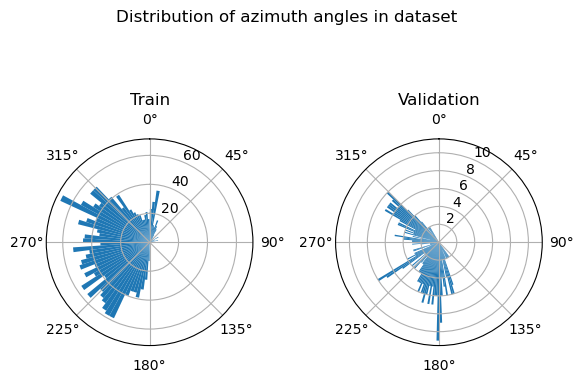

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "polar"})
for ax, data, data_type in zip(
    [ax1, ax2],
    [train_dataset.angles[:split_index], val_dataset.angles[split_index:]],
    ["Train", "Validation"],
):
    ax.hist(data / 180 * 3.14, bins=100)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title(data_type)
fig.suptitle("Distribution of azimuth angles in dataset")
plt.subplots_adjust(wspace=0.4)
plt.show()

## CUDA (GPU Acceleration)
To use the GPU for training and inference, one just needs to move the tensors and `nn.Modules` for compute to the GPU (CUDA) device by using `.to(device)` call:
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
input_data = input_data.to(device)
```

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training Loop
Our main training loop is defined below. 

To thoroughly conduct the experiments, <strong style="color:red;">you should try out all the combinations (model/backbone, model/representation, model/readout). For each combination, you should tune the batch size and learning rate.</strong> Note the optimal learning rate will vary from case to case.

The optimal combination should yield a validation error less than 15 degrees (mean) and 5 degress (median) after trained to convergence.

Tip: First try to get all the TODOs implemented. Verify the implementation by making sure the training pipeline runs without error and the training loss and validation error is going down after every epoch. Start with a small number of epochs (e.g. 3) on your laptop or codespaces. Once you are confident the code works, move to a GPU environment for full-scale experiments and hyperparameter tuning.

In [6]:
def evaluate(dataloader, model, criterion):
    """
    Evaluate the performance of a model on a given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        model (torch.nn.Module): The model to be evaluated.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        tuple: A tuple containing the average loss, evaluation metric (mean, median, and all values), and predictions.

    """
    model.eval()

    loss = []
    pred = []
    metric = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, vector_gt, angle_gt = batch
            inputs = inputs.to(device)
            angle_gt = angle_gt.to(device)
            vector_gt = vector_gt.to(device)
            outputs = model(inputs)
            loss.append(criterion(outputs, angle_gt, vector_gt).item())
            angle_pred = model.get_angle(outputs)
            pred.extend(angle_pred.tolist())
            angle_error = torch.abs(angle_pred - angle_gt)
            angle_error = torch.min(angle_error, 360 - angle_error)
            metric.extend(angle_error.tolist())

    metric = torch.tensor(metric)
    pred = torch.tensor(pred)

    return sum(loss) / len(loss), (metric.mean(), metric.median(), metric), pred

In [7]:
from tqdm.notebook import tqdm


def train_epoch(train_loader, val_loader, model, optimizer, criterion):
    """
    Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion.
    Args:
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
    Returns:
        tuple: A tuple containing the training loss, training performance, validation performance, and validation predictions.
    """
    model.train()

    for x, y_gt_vector, y_gt_angles in tqdm(train_loader, desc="Training", leave=False):

        x = x.to(device)
        y_gt_angles = y_gt_angles.to(device)
        y_gt_vector = y_gt_vector.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y_gt_angles, y_gt_vector)
        loss.backward()

        optimizer.step()

    train_loss, train_performance, _ = evaluate(train_loader, model, criterion)
    _, val_performance, val_pred = evaluate(val_loader, model, criterion)

    return train_loss, train_performance, val_performance, val_pred



In [8]:
import matplotlib.pyplot as plt


def plot_angle_historgram(pred, gt):
    """
    Plots a histogram of angles in polar coordinates.

    Parameters:
    - pred (array-like): Array of predicted angles in degrees.
    - gt (array-like): Array of ground truth angles in degrees.

    Returns:
    fig (matplotlib.figure.Figure): The generated figure object.
    """
    fig, ax = plt.subplots(1, subplot_kw={"projection": "polar"})
    for data, data_type in zip(
        [pred, gt],
        ["Prediction", "Ground Truth"],
    ):
        ax.hist(data / 180 * 3.14, bins=100, label=data_type, alpha=0.8)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.legend()
    plt.tight_layout()
    return fig

### Tool: TensorBoard
TensorBoard is a visualization tool designed to help better understand and debug machine learning models. It allows you to visualize metrics like loss, accuracy and other statistics. One of its key features is the ability to compare performance curves between different training runs, enabling you to see how changes in your model, hyperparameters, or data impact the results. This makes TensorBoard a valuable tool for optimizing model performance.

In [9]:
from torch.utils.tensorboard import SummaryWriter

exp_name = "replace_with_your_experiment_name"
writer = SummaryWriter(f"runs/{exp_name}", comment="")

for epoch in tqdm(range(cfg.epochs), desc="Epochs"):
    (
        train_loss,
        (train_error_mean, train_error_median, train_error_tensor),
        (val_err_mean, val_err_median, val_error_tensor),
        val_pred,
    ) = train_epoch(train_loader, val_loader, model, optimizer, criterion)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Error/train/mean", train_error_mean, epoch)
    writer.add_scalar("Error/train/median", train_error_median, epoch)
    writer.add_scalar("Error/val/mean", val_err_mean, epoch)
    writer.add_scalar("Error/val/median", val_err_median, epoch)
    writer.add_histogram("Error/val", train_error_tensor, epoch)
    writer.add_histogram("Pred/val", val_pred, epoch)

    writer.add_figure(
        "Polar Histogram",
        plot_angle_historgram(val_pred, dataset.angles[split_index:]),
        epoch,
    )

ModuleNotFoundError: No module named 'tensorboard'